# Import Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
from scipy import stats
import statsmodels.api as sm
from google.colab import files

# Load the Datasets

In [2]:
trader_data = pd.read_csv("/content/historical_data.csv")
sentiment_data = pd.read_csv("/content/fear_greed_index.csv")

In [3]:
trader_data['Timestamp IST'] = pd.to_datetime(trader_data['Timestamp IST'], format="%d-%m-%Y %H:%M")
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'], format="%Y-%m-%d")

In [4]:
trader_data['date'] = trader_data['Timestamp IST'].dt.date
sentiment_data['date'] = sentiment_data['date'].dt.date

In [17]:
def load_and_preprocess_data():
    trader_data = pd.read_csv("/content/historical_data.csv")
    sentiment_data = pd.read_csv("/content/fear_greed_index.csv")
    trader_data['Timestamp IST'] = pd.to_datetime(trader_data['Timestamp IST'], format='%d-%m-%Y %H:%M')
    trader_data['date'] = trader_data['Timestamp IST'].dt.date
    sentiment_data['date'] = pd.to_datetime(sentiment_data['date'], format='%Y-%m-%d').dt.date

    return trader_data, sentiment_data

# Merge Data

In [18]:
def merge_datasets(trader_data, sentiment_data):
    return pd.merge(trader_data, sentiment_data[['date', 'value', 'classification']], on='date', how='inner')

# Feature Engineering

In [19]:
def calculate_profitability_score(df):
    df['Normalized_PnL'] = (df['Closed PnL'] - df['Closed PnL'].min()) / (df['Closed PnL'].max() - df['Closed PnL'].min() + 1e-10)
    df['Normalized_Size'] = (df['Size USD'] - df['Size USD'].min()) / (df['Size USD'].max() - df['Size USD'].min() + 1e-10)

    # Sentiment mapping
    sentiment_map = {'Extreme Fear': 0.1, 'Fear': 0.3, 'Neutral': 0.5, 'Greed': 0.7, 'Extreme Greed': 0.9}
    df['Sentiment_Score'] = df['classification'].map(sentiment_map)

    # Profitability Score = (PnL * Sentiment) / (Size + Fee impact)
    df['Profitability_Score'] = (df['Normalized_PnL'] * df['Sentiment_Score']) / (df['Normalized_Size'] + df['Fee'] / df['Size USD'] + 1e-10)
    return df

# Sentiment Analysis

In [20]:
def analyze_sentiment(df):
    return df.groupby('classification').agg({
        'Closed PnL': ['mean', 'sum', 'count'],
        'Profitability_Score': 'mean',
        'Size USD': 'mean'
    }).reset_index()

# Visualization

**Profitability by Sentiment**

In [21]:
def visualize(df, performance_df):
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(8, 5))
    sns.barplot(x='classification', y=('Profitability_Score', 'mean'), data=performance_df, palette='viridis')
    plt.title('Avg. Profitability Score by Market Sentiment')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig('profitability_by_sentiment.png')
    plt.show()
    files.download('profitability_by_sentiment.png')
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='classification', y='Closed PnL', data=df, palette='coolwarm')
    plt.title('Closed PnL Distribution Across Sentiments')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
    plt.savefig('pnl_distribution.png')
    files.download('pnl_distribution.png')

# Statistical Analysis

In [22]:
def statistical_analysis(df):
    return stats.pearsonr(df['Sentiment_Score'], df['Profitability_Score'])

# Generate Insights

In [23]:
def generate_insights(df, perf_df, corr, p_val):
    insights = []
    insights.append("=== Trading Strategy Insights ===")
    insights.append(f"Correlation between Sentiment and Profitability Score: {corr:.3f} (p-value: {p_val:.3f})")
    best_sentiment = perf_df.loc[perf_df[('Profitability_Score', 'mean')].idxmax(), 'classification']
    insights.append(f"Best sentiment for profitability: {best_sentiment}")
    high_volume_trades = df[df['Size USD'] > df['Size USD'].quantile(0.75)]
    high_volume_sentiment = high_volume_trades['classification'].mode()[0] if not high_volume_trades.empty else 'N/A'
    insights.append(f"Most common sentiment for high-volume trades: {high_volume_sentiment}")
    insights.append("\nCreative Trading Strategy Suggestion:")
    insights.append("Implement a 'Sentiment Momentum Strategy':")
    insights.append("- Buy during 'Fear' or 'Extreme Fear' when Profitability Score > 0.5")
    insights.append("- Sell during 'Greed' or 'Extreme Greed' when Profitability Score < 0.3")
    insights.append("- Adjust position size based on normalized Sentiment Score")
    return "\n".join(insights)

/tmp/ipython-input-21-4166659003.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




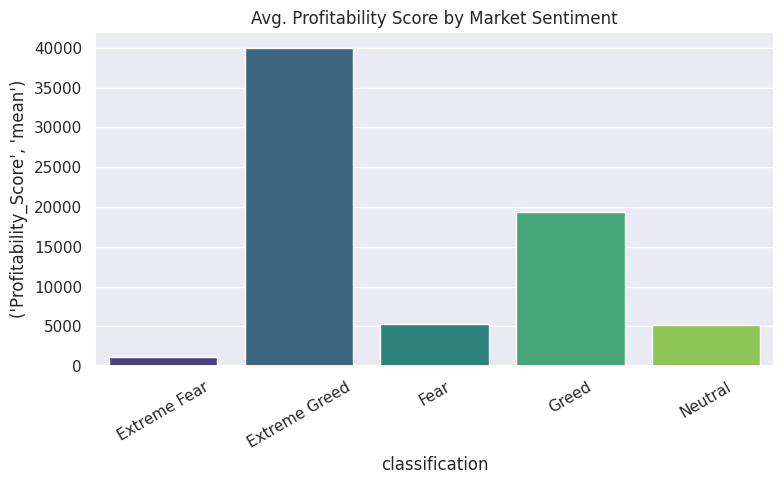

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-21-4166659003.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




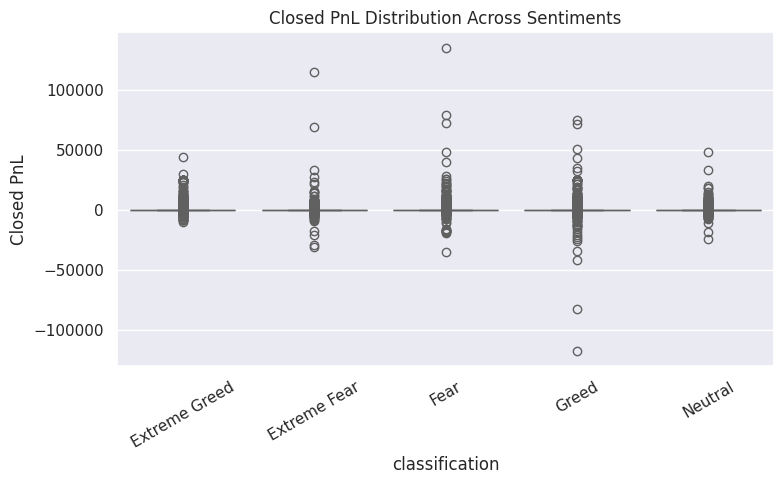

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Analysis complete. Visuals and insights saved.


<Figure size 640x480 with 0 Axes>

In [26]:
def main():
    trader_data, sentiment_data = load_and_preprocess_data()
    merged_data = merge_datasets(trader_data, sentiment_data)
    merged_data = calculate_profitability_score(merged_data)
    sentiment_perf = analyze_sentiment(merged_data)
    visualize(merged_data, sentiment_perf)
    corr, p_val = statistical_analysis(merged_data)
    insights = generate_insights(merged_data, sentiment_perf, corr, p_val)

    # Save insights
    with open('final_insights.txt', 'w') as f:
        f.write(insights)

    print("✅ Analysis complete. Visuals and insights saved.")

if __name__ == "__main__":
    main()


In [29]:
merged_data = merged_data.sort_values('Timestamp IST')
merged_data['Rolling_PnL'] = merged_data['Closed PnL'].rolling(window=3).mean()
merged_data['Rolling_Sentiment'] = merged_data['Sentiment_Score'].rolling(window=3).mean()


NameError: name 'merged_data' is not defined

In [30]:
trader_data, sentiment_data = load_and_preprocess_data()
# Merge data in the global scope
merged_data = merge_datasets(trader_data, sentiment_data)
# Calculate profitability score in the global scope
merged_data = calculate_profitability_score(merged_data)

# Lag Correlation Analysis

In [31]:
merged_data = merged_data.sort_values('Timestamp IST')
merged_data['Lagged_Sentiment'] = merged_data['Sentiment_Score'].shift(1)

from scipy import stats
lag_corr, lag_pval = stats.pearsonr(
    merged_data['Lagged_Sentiment'].fillna(0),
    merged_data['Profitability_Score'].fillna(0)
)

print(f"Lag Correlation: {lag_corr:.3f} (p-value: {lag_pval:.3f})")


Lag Correlation: 0.011 (p-value: 0.000)


In [32]:
sentiment_std = merged_data.groupby('date')['Sentiment_Score'].mean().rolling(3).std().mean()
pnl_std = merged_data.groupby('date')['Closed PnL'].mean().rolling(3).std().mean()

print(f"Sentiment Volatility (std): {sentiment_std:.4f}")
print(f"PnL Volatility (std): {pnl_std:.4f}")


Sentiment Volatility (std): 0.0509
PnL Volatility (std): 71.7429


# Win Rate by Sentiment Class

In [33]:
merged_data['Win'] = merged_data['Closed PnL'] > 0
win_rate_df = merged_data.groupby('classification')['Win'].mean().reset_index(name='Win Rate')
display(win_rate_df)


,classification,Win Rate
0,Extreme Fear,0.370607
1,Extreme Greed,0.464943
2,Fear,0.420768
3,Greed,0.384828
4,Neutral,0.396991


# Profitability by Trader & Sentiment

In [34]:
account_sentiment_matrix = merged_data.groupby(['Account', 'classification'])['Profitability_Score']\
                                      .mean().unstack().fillna(0)
display(account_sentiment_matrix)


classification,Extreme Fear,Extreme Greed,Fear,Greed,Neutral
Account,,,,,
0x083384f897ee0f19899168e3b1bec365f52a9012,1.501877e+02,9.697787e+02,4.968334e+02,1134.603259,8.443801e+02
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,3.846450e+02,2.504563e+05,5.986593e+02,1611.744030,1.367066e+04
0x271b280974205ca63b716753467d5a371de622ab,1.477345e+02,2.221888e+02,3.169825e+03,15992.773924,4.502206e+02
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,2.349811e+03,3.596901e+03,7.044897e+04,1066.548529,9.478167e+02
0x2c229d22b100a7beb69122eed721cee9b24011dd,8.776134e+01,8.917887e+02,4.452301e+02,460.783970,6.275470e+02
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,1.979447e+02,2.283683e+06,2.794125e+05,138427.993187,2.703403e+06
0x39cef799f8b69da1995852eea189df24eb5cae3c,1.983129e+02,1.593164e+03,6.292264e+02,815.229188,2.050265e+03
0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,1.811878e+02,2.157381e+03,8.375132e+04,223603.484634,6.614107e+05
0x420ab45e0bd8863569a5efbb9c05d91f40624641,2.846565e+02,1.403188e+03,3.067294e+02,565.734860,7.743797e+02


# KMeans Clustering of Trading Behaviors

In [36]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = merged_data[['Sentiment_Score', 'Closed PnL', 'Size USD', 'Fee']].copy()
features_scaled = StandardScaler().fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
merged_data['Behavior_Cluster'] = kmeans.fit_predict(features_scaled)

merged_data[['Sentiment_Score', 'Closed PnL', 'Behavior_Cluster']].head()


,Sentiment_Score,Closed PnL,Behavior_Cluster
83765,0.7,0.0,0
83764,0.7,0.0,0
83763,0.7,0.0,0
39049,0.9,0.0,0
39050,0.9,0.0,0


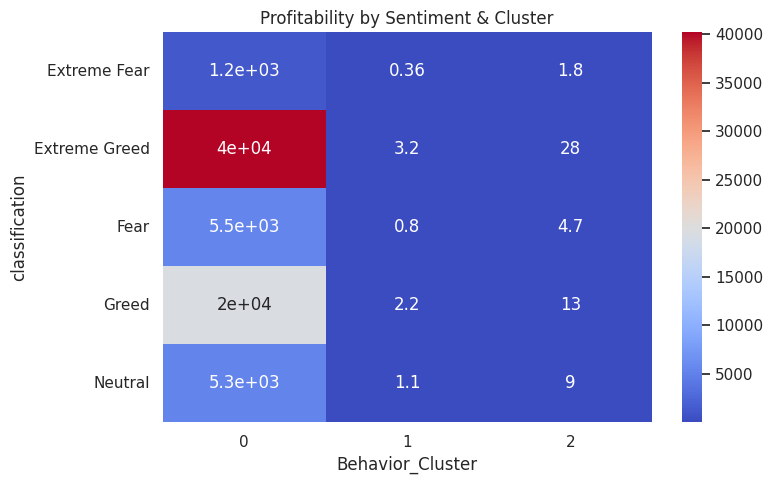

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = merged_data.pivot_table(
    values='Profitability_Score',
    index='classification',
    columns='Behavior_Cluster',
    aggfunc='mean'
)

plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title("Profitability by Sentiment & Cluster")
plt.tight_layout()
plt.savefig("heatmap_sentiment_cluster.png")
plt.show()


# Scatter Plot: Sentiment Score vs. Profitability Score

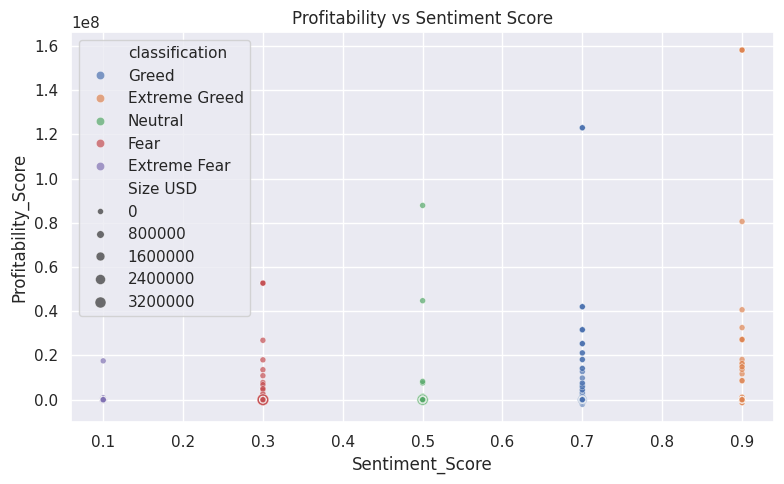

In [39]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='Sentiment_Score',
    y='Profitability_Score',
    size='Size USD',
    hue='classification',
    data=merged_data,
    alpha=0.7
)
plt.title("Profitability vs Sentiment Score")
plt.tight_layout()
plt.savefig("scatter_profitability_sentiment.png")
plt.show()


# Line Plot: Rolling Sentiment and PnL Over Time

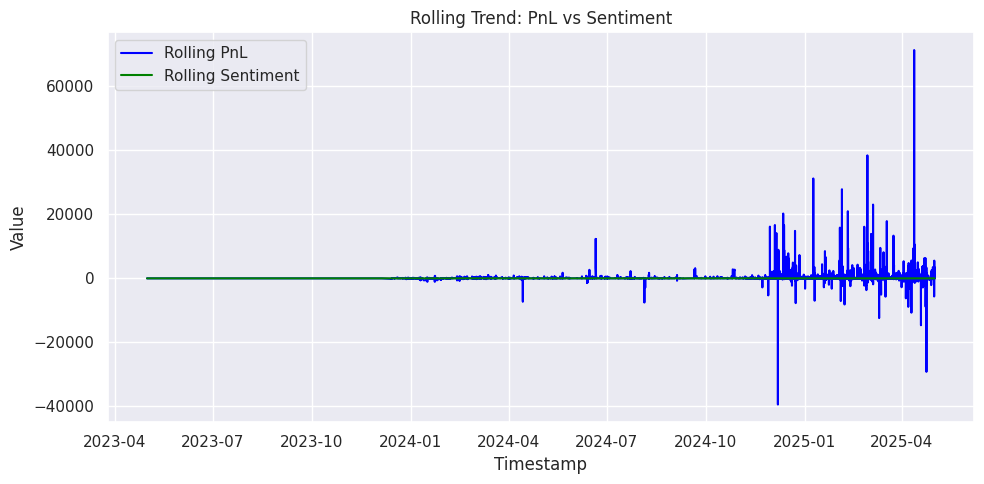

In [41]:
# Calculate rolling metrics
merged_data = merged_data.sort_values('Timestamp IST')
merged_data['Rolling_PnL'] = merged_data['Closed PnL'].rolling(window=3).mean()
merged_data['Rolling_Sentiment'] = merged_data['Sentiment_Score'].rolling(window=3).mean()

# Now plot the rolling trends
plt.figure(figsize=(10, 5))
plt.plot(merged_data['Timestamp IST'], merged_data['Rolling_PnL'], label='Rolling PnL', color='blue')
plt.plot(merged_data['Timestamp IST'], merged_data['Rolling_Sentiment'], label='Rolling Sentiment', color='green')
plt.title("Rolling Trend: PnL vs Sentiment")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.savefig("rolling_trends.png")
plt.show()